<h1><center>LOG REGRESSION  </center> </h1>
      
<h2><center>on Churn-Data with imbalanced groups </center></h2>

Jupyter notebook on log regression using differetn methods to remove imbalance and running a model over each. This is the result of the work done after three weeks @ Ironhack - fulltime bootcamp. This notebook is ment o be shared among other participants.  
  
<center >FEEDBACK IS HIGHLY APPRECIATED!</center>

I do not really know how to do packages, which is why my funstions are still all in this notebook. The first block of funcitons is used for correlation analysis of categoricals, which was new to me, sources are cited  
      
### 0. Introduction
    
We start by having a look at the data and importing all necessary libraries:    
Furthermore I place here the functions for thecorrelation heatmap of categoricals (scroll down



In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from scipy.stats import probplot
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import os
import sys

%matplotlib inline

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows', None)

data = pd.read_csv('customer_churn.csv')

data.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [2]:
#calculation of eta
#https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = numerator/denominator
    return eta

#this function I did get from kaggle, they are needed to do the categorial correlation using cramers
#https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792
def convert(data, to):
    converted = None
    if to == 'array':
        if isinstance(data, np.ndarray):
            converted = data
        elif isinstance(data, pd.Series):
            converted = data.values
        elif isinstance(data, list):
            converted = np.array(data)
        elif isinstance(data, pd.DataFrame):
            converted = data.as_matrix()
    elif to == 'list':
        if isinstance(data, list):
            converted = data
        elif isinstance(data, pd.Series):
            converted = data.values.tolist()
        elif isinstance(data, np.ndarray):
            converted = data.tolist()
    elif to == 'dataframe':
        if isinstance(data, pd.DataFrame):
            converted = data
        elif isinstance(data, np.ndarray):
            converted = pd.DataFrame(data)
    else:
        raise ValueError("Unknown data conversion: {}".format(to))
    if converted is None:
        raise TypeError('cannot handle data conversion of type: {} to {}'.format(type(data),to))
    else:
        return converted

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = numerator/denominator
    return eta

def associations(dataset, nominal_columns=None, mark_columns=False, theil_u=False, plot=True,
                          return_results = False, **kwargs):
    """
    Calculate the correlation/strength-of-association of features in data-set with both categorical (eda_tools) and
    continuous features using:
     - Pearson's R for continuous-continuous cases
     - Correlation Ratio for categorical-continuous cases
     - Cramer's V or Theil's U for categorical-categorical cases
    :param dataset: NumPy ndarray / Pandas DataFrame
        The data-set for which the features' correlation is computed
    :param nominal_columns: string / list / NumPy ndarray
        Names of columns of the data-set which hold categorical values. Can also be the string 'all' to state that all
        columns are categorical, or None (default) to state none are categorical
    :param mark_columns: Boolean (default: False)
        if True, output's columns' names will have a suffix of '(nom)' or '(con)' based on there type (eda_tools or
        continuous), as provided by nominal_columns
    :param theil_u: Boolean (default: False)
        In the case of categorical-categorical feaures, use Theil's U instead of Cramer's V
    :param plot: Boolean (default: True)
        If True, plot a heat-map of the correlation matrix
    :param return_results: Boolean (default: False)
        If True, the function will return a Pandas DataFrame of the computed associations
    :param kwargs:
        Arguments to be passed to used function and methods
    :return: Pandas DataFrame
        A DataFrame of the correlation/strength-of-association between all features
    """
    dataset = convert(dataset, 'dataframe')
    columns = dataset.columns
    if nominal_columns is None:
        nominal_columns = list()
    elif nominal_columns == 'all':
        nominal_columns = columns
    corr = pd.DataFrame(index=columns, columns=columns)
    for i in range(0,len(columns)):
        for j in range(i,len(columns)):
            if i == j:
                corr[columns[i]][columns[j]] = 1.0
            else:
                if columns[i] in nominal_columns:
                    if columns[j] in nominal_columns:
                        if theil_u:
                            corr[columns[j]][columns[i]] = theils_u(dataset[columns[i]],dataset[columns[j]])
                            corr[columns[i]][columns[j]] = theils_u(dataset[columns[j]],dataset[columns[i]])
                        else:
                            cell = cramers_v(dataset[columns[i]],dataset[columns[j]])
                            corr[columns[i]][columns[j]] = cell
                            corr[columns[j]][columns[i]] = cell
                    else:
                        cell = correlation_ratio(dataset[columns[i]], dataset[columns[j]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
                else:
                    if columns[j] in nominal_columns:
                        cell = correlation_ratio(dataset[columns[j]], dataset[columns[i]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
                    else:
                        cell, _ = ss.pearsonr(dataset[columns[i]], dataset[columns[j]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
    corr.fillna(value=np.nan, inplace=True)
    if mark_columns:
        marked_columns = ['{} (nom)'.format(col) if col in nominal_columns else '{} (con)'.format(col) for col in columns]
        corr.columns = marked_columns
        corr.index = marked_columns
    if plot:
        plt.figure(figsize=(20,20))#kwargs.get('figsize',None))
        sns.set(font_scale=1.4)
        sns.heatmap(corr, annot=kwargs.get('annot',True), vmin=-1, vmax=1, fmt=kwargs.get('fmt','.2f'), cmap='seismic')
        plt.show()
        if return_results:
            return corr

# 1. Data Exploration and Manipulation  

We further explore the data, look for missing data, types of data etc.

In [3]:
data.shape

(7043, 21)

In [4]:
data['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [5]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [6]:
def display_missing(df):
    """shows the number of missing values of each column for a date_frame, if there is one"""
    for col in df.columns.tolist():
        if df[col].isnull().sum():
            print('{} column missing values: {}/{}'.format(col, df[col].isnull().sum(), len(df)))
    print ('Done checking for missing values')
    
display_missing(data)
#no missing values

Done checking for missing values


In [7]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Some types of variables do not seem right, such as SeniorCitizen (is in fact a categorical) and TotalCharges, which is in fact a numerical.  
We further explore some of the realtionships between variables, just to get a feeling for the data. We try different combinations - below are two that are interesting: The first one probably relates to familiy, the second one to Internet and its services - probably some correlations here... we will see later...

In [8]:
pd.crosstab(data['Partner'], data['Dependents'])

Dependents,No,Yes
Partner,,
No,3280,361
Yes,1653,1749


In [9]:
pd.crosstab(data['InternetService'], data['OnlineSecurity'])

OnlineSecurity,No,No internet service,Yes
InternetService,,,
DSL,1241,0,1180
Fiber optic,2257,0,839
No,0,1526,0


## 1.2 Transforming Variables


As mentioned above, we have to cahnge the dtype of two variabels, and drop the id:

In [10]:
data['SeniorCitizen'] = data['SeniorCitizen'].astype('object')
data['TotalCharges'] = list(map(lambda x: x.replace(' ', ''), data['TotalCharges']))
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])

In [11]:
data.drop(['customerID'], axis =1, inplace = True)

## 1.3 Numericals 
### 1.3.1 Correlation among numerical X

<AxesSubplot:>

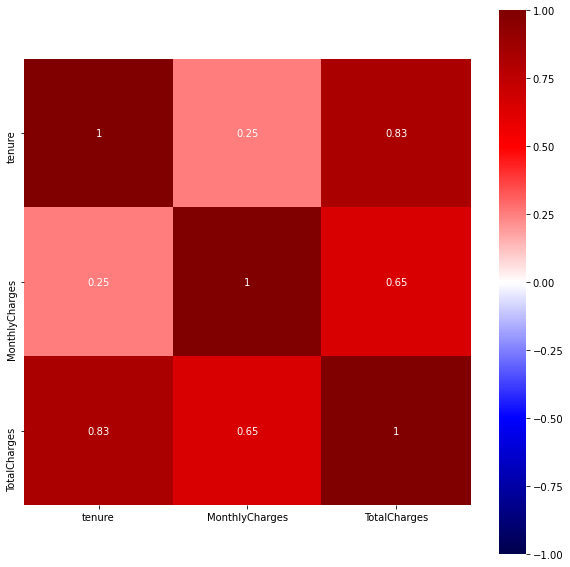

In [12]:
data_nums = data.select_dtypes(include = np.number)
data_cats = data.select_dtypes(include='object')

plt.figure(figsize=(10,10))
sns.heatmap(data_nums.corr().round(2),vmin=-1, vmax=1, center=0, annot = True,square=True,
cmap='seismic')

### 1.3.2 Feature engeneering on numericals

`Tenure`, `TotalCharges` and `MonthlyCharges` have a very high correlation - looking at the data it seems like we have a pretty clear pattern which is:  
  
`TotalCharges` = `tenure` * `MonthlyCharges`  
  
We therefore calculate this and compare the newly generated column with `TotalCharges` and compare using a pairplot:

In [13]:
data_nums['ten_*MonthCh_'] = data_nums['tenure']*data_nums['MonthlyCharges']
data_nums.head()

,tenure,MonthlyCharges,TotalCharges,ten_*MonthCh_
0,1,29.85,29.85,29.85
1,34,56.95,1889.50,1936.30
2,2,53.85,108.15,107.70
3,45,42.30,1840.75,1903.50
4,2,70.70,151.65,141.40


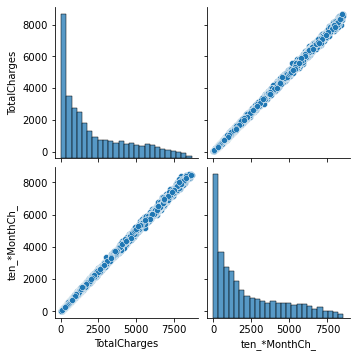

In [14]:
sns.pairplot(data_nums[['TotalCharges','ten_*MonthCh_']])

It is very clear that our assumption is correct!  

We therefore drop `TotalCharges` and the newly generated column, as they do not give us furhter information. `TotalCharges` can be easily expressed by tenure and MonthlyCharge, the strong correlation among numericals is now gone.

We fruther use another pairplot with hue = Churn to investigate the influence of our numericals on our target. We see here a clear pattern. Churn mostly occurs for low tenure and high monthly charges.

In [15]:
data_nums.drop(['TotalCharges', 'ten_*MonthCh_'], axis=1, inplace = True)

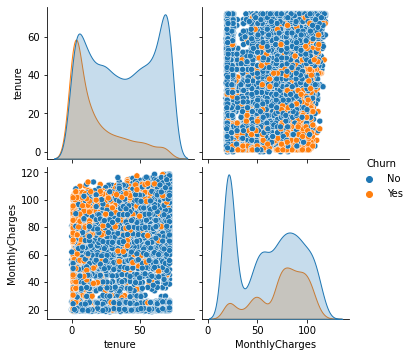

In [16]:
sns.pairplot(data[['tenure','MonthlyCharges', 'Churn']], hue = 'Churn')

## 1.4 Categoricals

We do countplots for all categoricals, in order to see the relationship to our target `Churn` we define the hue for that, so for each label of each category we see the differences. We then filter for those categoricals that seem to have an influence on our target

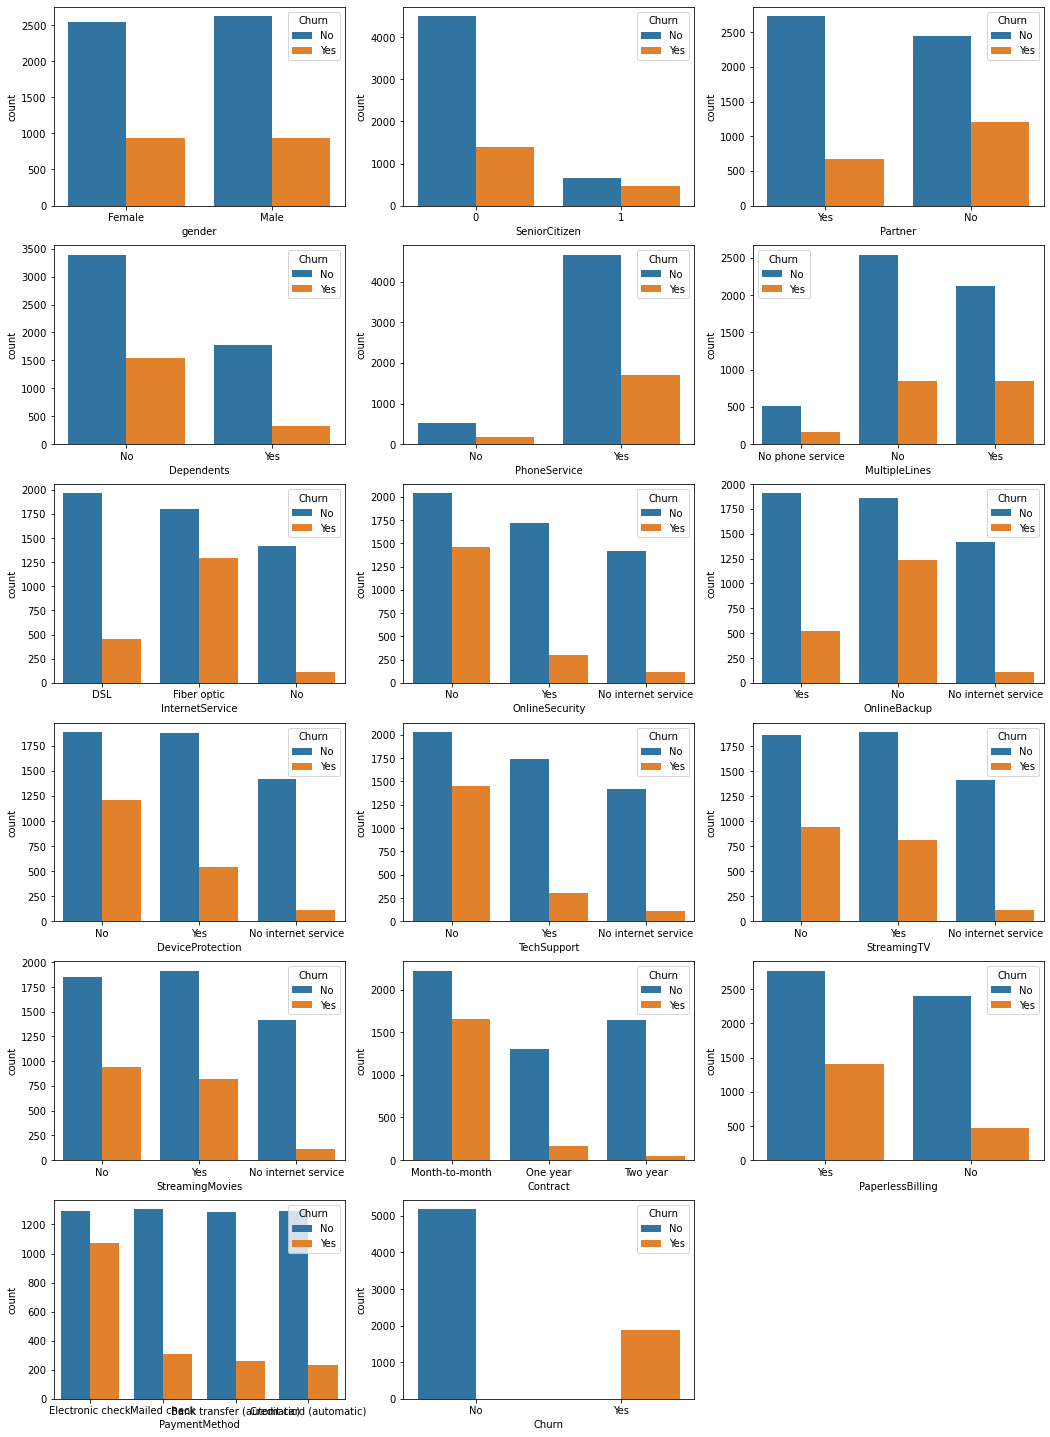

In [17]:
data_cats_cols = data_cats.columns
fig,axs = plt.subplots(ncols=7, nrows=3, figsize =(10, 30))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(data_cats_cols, 1):    
    plt.subplot(7, 3, i)
    sns.countplot(x = feature, hue = 'Churn', data= data_cats)
plt.show()

### 1.4.1 Choosing categroicals for our model

The following variables seem to be promissing:
1) SeniorCitizen
2) partner, dependents (interesting for feature `family`)
3) InternetService
4) online securtiy, online backup, devicePrtoection, TechSupport (all with negative corr. maybe generate one feature)
5) Contract
6) PaperlessBillng
7) PaymentMethod

Streamng TV and Streaming Movies has some influence on Churn, but only for `no Internet connections`, which is already representes by 5 other variables. Therefore we drop these two, as well as all the others with no influence on Y.

Very interesting is point 2 and 4 with a lot of variables pointing in the same direction, we will investigate that using a heatmap for categoricals (which is why we have that many functions in the begining)

First we drop the categoricals that are not needed:
      

In [18]:
data_cats.drop(['gender', 'PhoneService', 'MultipleLines','StreamingTV', 'StreamingMovies'], axis=1, inplace = True)

In [19]:
data_cats.head()
data_cats.shape

(7043, 12)

### 1.4.2 Correlation among categoricals

We have eleven categoricals left. As the heatmap below shows there is medium correlation between Partner and dependent. A log Regression is can deal with minor correaltions, we keep these as they are.

The other 5 features realted to tech support and service and online Securtiy are all highly related to each other as shown below. We will sum them up four of them to `TechSupport_Security`.

In [20]:
catcols= list(data_cats.columns)

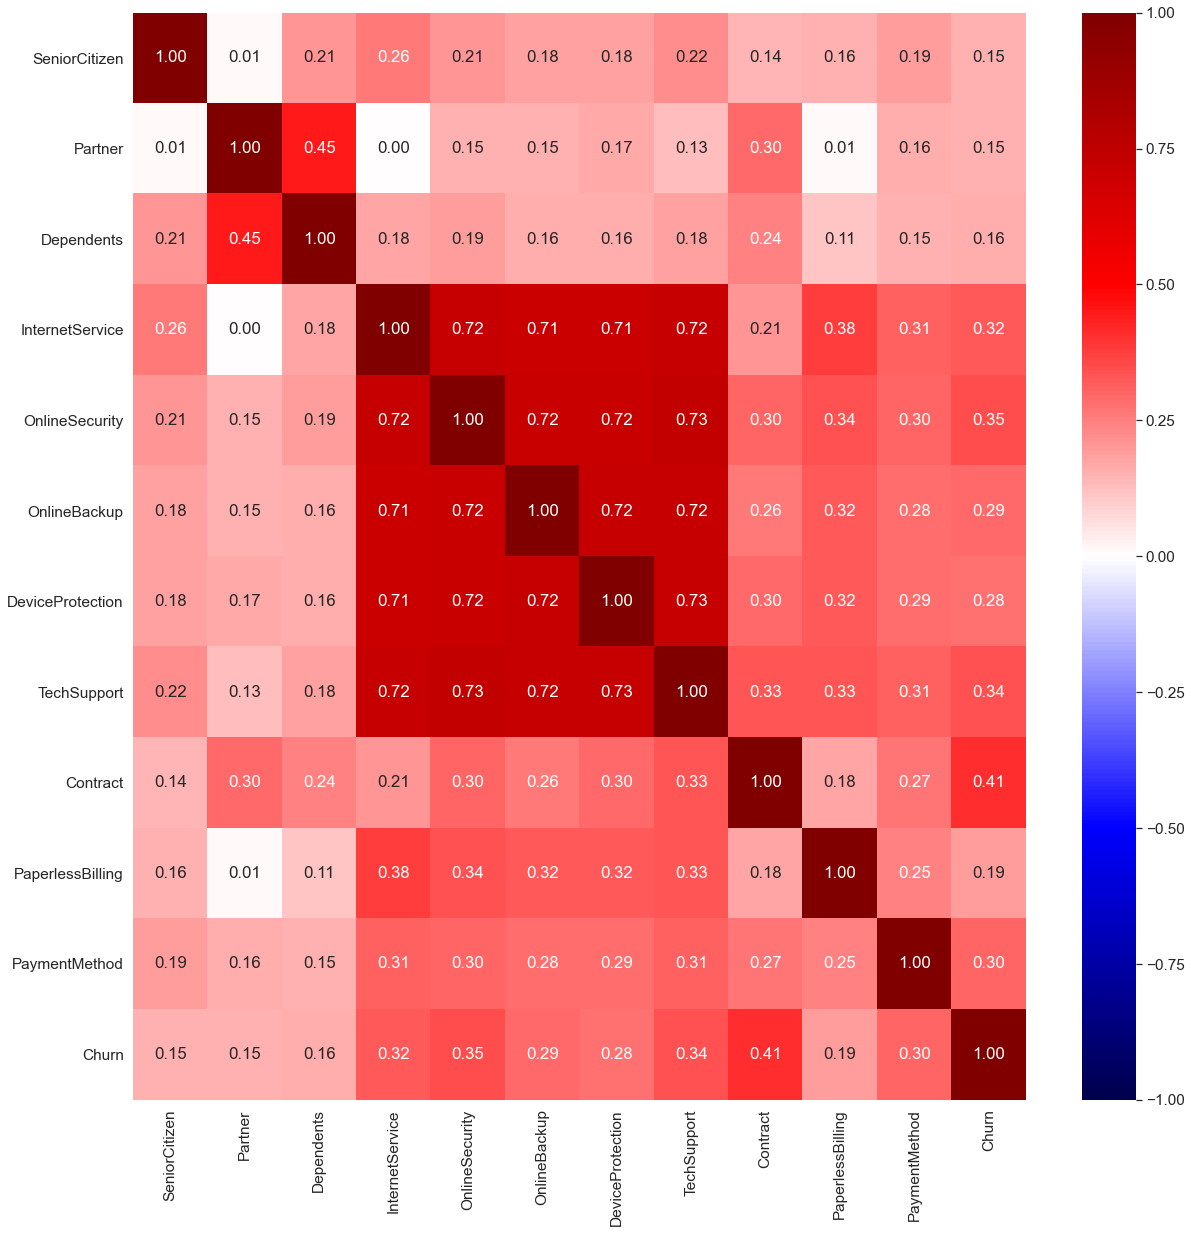

In [21]:
results = associations(data_cats,nominal_columns=catcols, return_results=True)

### 1.4.3 Featuer generation on Categoricals

The idea is to generate a featuer out of 4 of these 5 categoricals and therefore get rid of all the correlation while havein a simpler model without loosing any information.
In order to be able to sum theses 4 categoricals up, we define the labels of these 4 as follows:    
1) 'no internet connetction' as dummy variable  (we use 2)  
2) 'no service booked' as 0  
3) 'service booked' as 1  

After summing up the encoded variables we should have a new feature with a ordinal distiribution from 0 to 4.
regarding the dummy variable we check if the cases are the same with no Internet Service (the 5th variable), if so, we then assign a 0 to those cases (as the information of not haveing a internet connection is then already represented by internet service:


In [22]:
data_cats['TechSupport'].value_counts()
data_cats['DeviceProtection'].value_counts()
data_cats['OnlineBackup'].value_counts()
data_cats['OnlineSecurity'].value_counts()

No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64

In [23]:
#Defining ordered calues for each category using pandas Categorical
ordcat_tech= pd.Categorical(data_cats['TechSupport'], categories=['No', 'Yes', 'No internet service'], ordered=True)

In [24]:
#Factoizing them with pandas factorizer
tech, unique = pd.factorize(ordcat_tech, sort=True)
data_cats['TechSupport'] = tech
data_cats['DeviceProtection'] = tech
data_cats['OnlineBackup'] = tech
data_cats['OnlineSecurity'] = tech

In [25]:
data_cats.head()

,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,Churn
0,0,Yes,No,DSL,0,0,0,0,Month-to-month,Yes,Electronic check,No
1,0,No,No,DSL,0,0,0,0,One year,No,Mailed check,No
2,0,No,No,DSL,0,0,0,0,Month-to-month,Yes,Mailed check,Yes
3,0,No,No,DSL,1,1,1,1,One year,No,Bank transfer (automatic),No
4,0,No,No,Fiber optic,0,0,0,0,Month-to-month,Yes,Electronic check,Yes


In [26]:
#check if there are any rows with no services but internet
data_cats[((data_cats['InternetService']=='DSL') | (data_cats['InternetService']=='Fiber optic')) &
           ((data_cats['OnlineSecurity'] == 2) |
            (data_cats['OnlineBackup'] == 2) |
            (data_cats['DeviceProtection'] == 2) |
          (data_cats['TechSupport'] == 2))]


,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,Churn


As shown above, the labels no Internet Service refer to absolutely the same for all customers, which is why it is enough if this information is represented in the variable InternetService. Therefore we encode "no Internet Service with the dummy variable now to 0.  

The rest is easy, we sum the four columns up to the newly generated feature `TechSupSec` (Tech - Support - Security), the 'lost' label no internet connection is well representd in  `InternetService`

In [27]:
data_cats['OnlineSecurity'] = data_cats['OnlineSecurity'].apply(lambda x: 0 if x ==2 else x)
data_cats['OnlineBackup'] = data_cats['OnlineBackup'].apply(lambda x: 0 if x ==2 else x)
data_cats['DeviceProtection'] = data_cats['DeviceProtection'].apply(lambda x: 0 if x ==2 else x)
data_cats['TechSupport'] = data_cats['TechSupport'].apply(lambda x: 0 if x ==2 else x)

In [28]:
data_cats['TechSupSec'] = data_cats[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport']].sum( axis=1)
data_cats['TechSupSec'].value_counts()

0    4999
4    2044
Name: TechSupSec, dtype: int64

In [29]:
data_cats.drop(['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport'], axis = 1, inplace = True)

In [30]:
data_cats.head()

,SeniorCitizen,Partner,Dependents,InternetService,Contract,PaperlessBilling,PaymentMethod,Churn,TechSupSec
0,0,Yes,No,DSL,Month-to-month,Yes,Electronic check,No,0
1,0,No,No,DSL,One year,No,Mailed check,No,0
2,0,No,No,DSL,Month-to-month,Yes,Mailed check,Yes,0
3,0,No,No,DSL,One year,No,Bank transfer (automatic),No,4
4,0,No,No,Fiber optic,Month-to-month,Yes,Electronic check,Yes,0


# 2. Data Transformation
## 2.1 Transformation of numericals

In [31]:
def feat_log_box(df, feature, bins):
    """makes a log Transformation and a boxcox transformation of a feature of a dataframe. \n
    0 values are replaced with the mean in the transformation: \n
    plots 3 distplots next to each other for comparison \n
    tales 3 arguments (df, feature, bins)"""
    df[feature+'_log'] = list(map(lambda x: np.log(x) if np.isfinite(x) and x!=0 else np.NAN, df[feature]))
    df[feature+'_log'] = df[feature+'_log'].fillna(np.mean(df[feature+'_log']))
    df[feature+'_boxcox'] = np.where(df[feature]<=0,0,df[feature])
    mean = np.sum(df[feature+'_boxcox'])/len(df[df[feature+'_boxcox']>0])
    df[feature+'_boxcox'] = df[feature+'_boxcox'].replace(0,mean)
    xt, lmbda = stats.boxcox(df[feature+'_boxcox'])
    df[feature+'_boxcox'] = xt
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,4))
    sns.distplot(df[feature], bins, ax=ax1)
    ax1.set_title(feature)
    sns.distplot(df[feature+'_log'], bins, ax=ax2)
    ax2.set_title(feature + '_log')
    sns.distplot(xt, bins, ax=ax3)
    ax3.set_title(feature + '_boxcox')


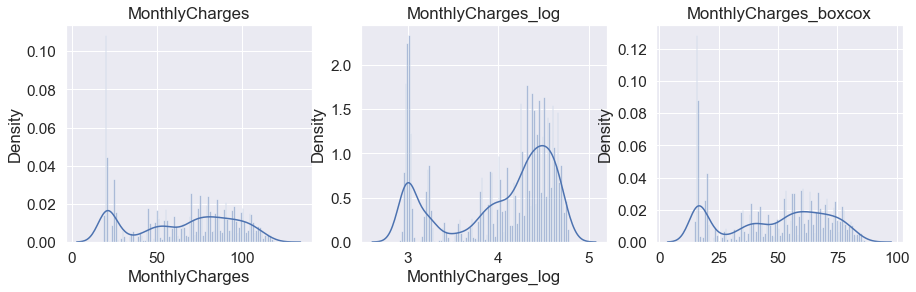

In [32]:
feat_log_box(data_nums, 'MonthlyCharges', 100)

In [33]:
data_nums.drop(['MonthlyCharges', 'MonthlyCharges_boxcox'], axis=1, inplace = True)

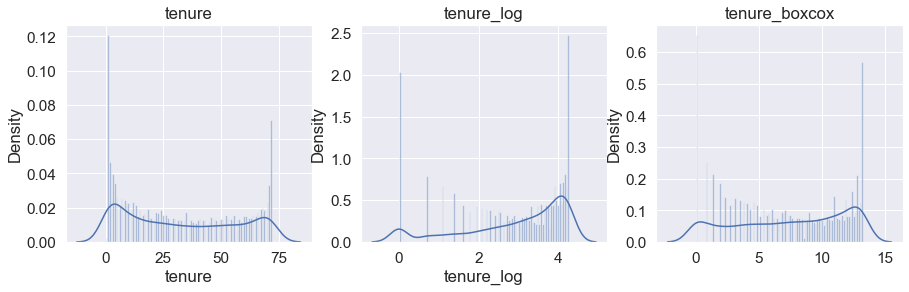

In [34]:
feat_log_box(data_nums, 'tenure', 100)

In [35]:
data_nums.drop(['tenure'], axis=1, inplace = True)

## 2.2 Encode Categoricals

In [36]:
data_cats.drop(['Churn'], axis =1, inplace = True)

In [37]:
data_cats.head()

,SeniorCitizen,Partner,Dependents,InternetService,Contract,PaperlessBilling,PaymentMethod,TechSupSec
0,0,Yes,No,DSL,Month-to-month,Yes,Electronic check,0
1,0,No,No,DSL,One year,No,Mailed check,0
2,0,No,No,DSL,Month-to-month,Yes,Mailed check,0
3,0,No,No,DSL,One year,No,Bank transfer (automatic),4
4,0,No,No,Fiber optic,Month-to-month,Yes,Electronic check,0


In [38]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='error', drop='first').fit(data_cats)
encoder.get_feature_names()
# encoder.categories_
encoded = encoder.transform(data_cats).toarray()
encoded

array([[0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 1., ..., 1., 0., 0.],
       [1., 1., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [39]:
data_cats_enc = pd.DataFrame(encoded)
data_cats_enc.columns = encoder.get_feature_names()

In [40]:
data_cats_enc.head()

,x0_1,x1_Yes,x2_Yes,x3_Fiber optic,x3_No,x4_One year,x4_Two year,x5_Yes,x6_Credit card (automatic),x6_Electronic check,x6_Mailed check,x7_4
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


## 2.3 Scaling numericals - Standard Scaler

In [41]:
transformer = StandardScaler().fit(data_nums)
transformed = transformer.transform(data_nums)

In [42]:
data_nums_sc = pd.DataFrame(transformed)
data_nums_sc.columns = data_nums.columns
data_nums_sc.head()

,MonthlyCharges_log,tenure_log,tenure_boxcox
0,-1.052744,-2.204123,-1.700335
1,0.034080,0.459646,0.302643
2,-0.060087,-1.680528,-1.514568
3,-0.466249,0.671382,0.645154
4,0.397940,-1.680528,-1.514568


In [43]:
y = data['Churn']
X = np.concatenate((transformed, encoded), axis=1)

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

In [45]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train, y_train)

In [46]:
classification.score(X_test, y_test)

0.8034066713981547

In [47]:
predictions = classification.predict(X_test)
classification.score(X_test, y_test)

0.8034066713981547

In [48]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[1901,  197],
       [ 357,  363]], dtype=int64)

## 2.4 Removing imbalance

starting with oversampling
generating a new dataframe data 2 of the already transfomred features

In [49]:
#generating dataframe data2 of processed/transformed
data1= pd.concat([data_nums_sc, data_cats_enc], axis=1)
data1.head()

,MonthlyCharges_log,tenure_log,tenure_boxcox,x0_1,x1_Yes,x2_Yes,x3_Fiber optic,x3_No,x4_One year,x4_Two year,x5_Yes,x6_Credit card (automatic),x6_Electronic check,x6_Mailed check,x7_4
0,-1.052744,-2.204123,-1.700335,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.034080,0.459646,0.302643,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.060087,-1.680528,-1.514568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,-0.466249,0.671382,0.645154,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.397940,-1.680528,-1.514568,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [50]:
data2 = data1
data2['Churn'] = data['Churn']
counts = data2['Churn'].value_counts()
yes = data2[data2['Churn']=='Yes'].sample(counts[0], replace=True)
no = data2[data2['Churn']=='No']
data_ov = pd.concat([yes,no], axis=0)
data_ov = data_ov.sample(frac=1)
data_ov['Churn'].value_counts()

Yes    5174
No     5174
Name: Churn, dtype: int64

In [51]:
y_ov = data_ov['Churn']
data_ov.drop(['Churn'], axis =1, inplace=True)
X_ov = data_ov

### 2.4.1 Random oversampler

In [52]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X, y)

In [53]:
y_ros.value_counts()

Yes    5174
No     5174
Name: Churn, dtype: int64

### 2.4.2 Undersampling

In [54]:
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X, y)

In [55]:
y_rus.value_counts()

No     1869
Yes    1869
Name: Churn, dtype: int64

### 2.4.3 Synthetic Minority Oversampling TEchnique (SMOTE)

In [56]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_sm, y_sm = smote.fit_sample(X, y)
y_sm.value_counts()

Yes    5174
No     5174
Name: Churn, dtype: int64

In [57]:
y_sm.value_counts()

Yes    5174
No     5174
Name: Churn, dtype: int64

### 2.4.4 UnderSampling using TomekLinks 

In [58]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks('majority')
X_tl, y_tl = tl.fit_sample(X, y)
y_tl.value_counts()

No     4643
Yes    1869
Name: Churn, dtype: int64

In [59]:
X_tl2, y_tl2 = tl.fit_sample(X_tl, y_tl)
y_tl2.value_counts()

No     4468
Yes    1869
Name: Churn, dtype: int64

# 3. Running models

normal oversampling (ov)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_ov, y_ov, test_size=0.4, random_state=1)

In [61]:
classification_ov = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train, y_train)

In [62]:
classification_ov.score(X_test, y_test)

0.7615942028985507

random oversampling (ros)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.4, random_state=1)

In [64]:
classification_ros = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train, y_train)

In [65]:
classification_ros.score(X_test, y_test)

0.7635265700483091

random undersampling (rus)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.4, random_state=1)

In [67]:
classification_rus = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train, y_train)

In [68]:
classification_rus.score(X_test, y_test)

0.7633689839572193

 Synthetic Minority Oversampling TEchnique (SMOTE) (sm)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.4, random_state=1)

In [70]:
classification_sm = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train, y_train)

In [71]:
classification_sm.score(X_test, y_test)

0.758695652173913

UnderSampling using TomekLinks 

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X_tl2, y_tl2, test_size=0.4, random_state=1)

In [73]:
classification_tl2 = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train, y_train)

In [74]:
classification_tl2.score(X_test, y_test)

0.8118343195266272